In [1]:
import tensorflow as tf
import os

from pitchfuncs import WMSE
from pitchfuncs import InversePCA
from pitchfuncs import emulator
from pitchfuncs import ns
import pandas as pd
import scipy
import numpy as np
import corner

2024-03-21 14:46:28.190280: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 14:46:28.190307: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-21 14:46:28.191142: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-21 14:46:28.196031: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-21 14:46:28.701659: W tensorflow/compiler/tf2

In [2]:
"""
Load in grid
"""

df = pd.read_hdf('/home/oxs235/datastorage/repos_data/ojscutt/pitchfork/data/bob.h5', key='df') #change if accessing from RDS

In [3]:
model = df
model = model[(model['star_age'] >= 4) & (model['star_age'] <= 6)]
model = model[(model['initial_mass'] >= 0.9) & (model['initial_mass'] <= 1.1)]
model = model[(model['initial_Yinit'] >= 0.28) & (model['initial_Yinit'] <= 0.3)]
model = model[(model['initial_Zinit'] >= 0.01) & (model['initial_Zinit'] <= 0.02)]
model = model[(model['initial_MLT'] >= 1.9) & (model['initial_MLT'] <= 2.1)]
model = model.sample(n=1)

inputs = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']
outputs = ['radius', 'luminosity', 'surface_Z'] + [f'nu_0_{i+1}' for i in range(5,40)]

model_inps = model[inputs]
model_outs = model[outputs]

model

,initial_mass,initial_Zinit,initial_Yinit,initial_MLT,star_age,radius,luminosity,effective_T,surface_Z,nu_0_4,...,log_nu_0_31_std,log_nu_0_32_std,log_nu_0_33_std,log_nu_0_34_std,log_nu_0_35_std,log_nu_0_36_std,log_nu_0_37_std,log_nu_0_38_std,log_nu_0_39_std,log_nu_0_40_std
3301783,0.96,0.016037,0.28,1.9,4.504841,0.968248,0.857865,5649.251765,0.014709,697.74652,...,0.767043,0.768108,0.769345,0.770672,0.769856,0.770643,0.770621,0.76938,0.767115,0.764841


In [4]:
model.to_json("example_model.json")
model = pd.read_json("example_model.json")

In [5]:
model

,initial_mass,initial_Zinit,initial_Yinit,initial_MLT,star_age,radius,luminosity,effective_T,surface_Z,nu_0_4,...,log_nu_0_31_std,log_nu_0_32_std,log_nu_0_33_std,log_nu_0_34_std,log_nu_0_35_std,log_nu_0_36_std,log_nu_0_37_std,log_nu_0_38_std,log_nu_0_39_std,log_nu_0_40_std
3301783,0.96,0.016037,0.28,1.9,4.504841,0.968248,0.857865,5649.251765,0.014709,697.74652,...,0.767043,0.768108,0.769345,0.770672,0.769856,0.770643,0.770621,0.76938,0.767115,0.764841


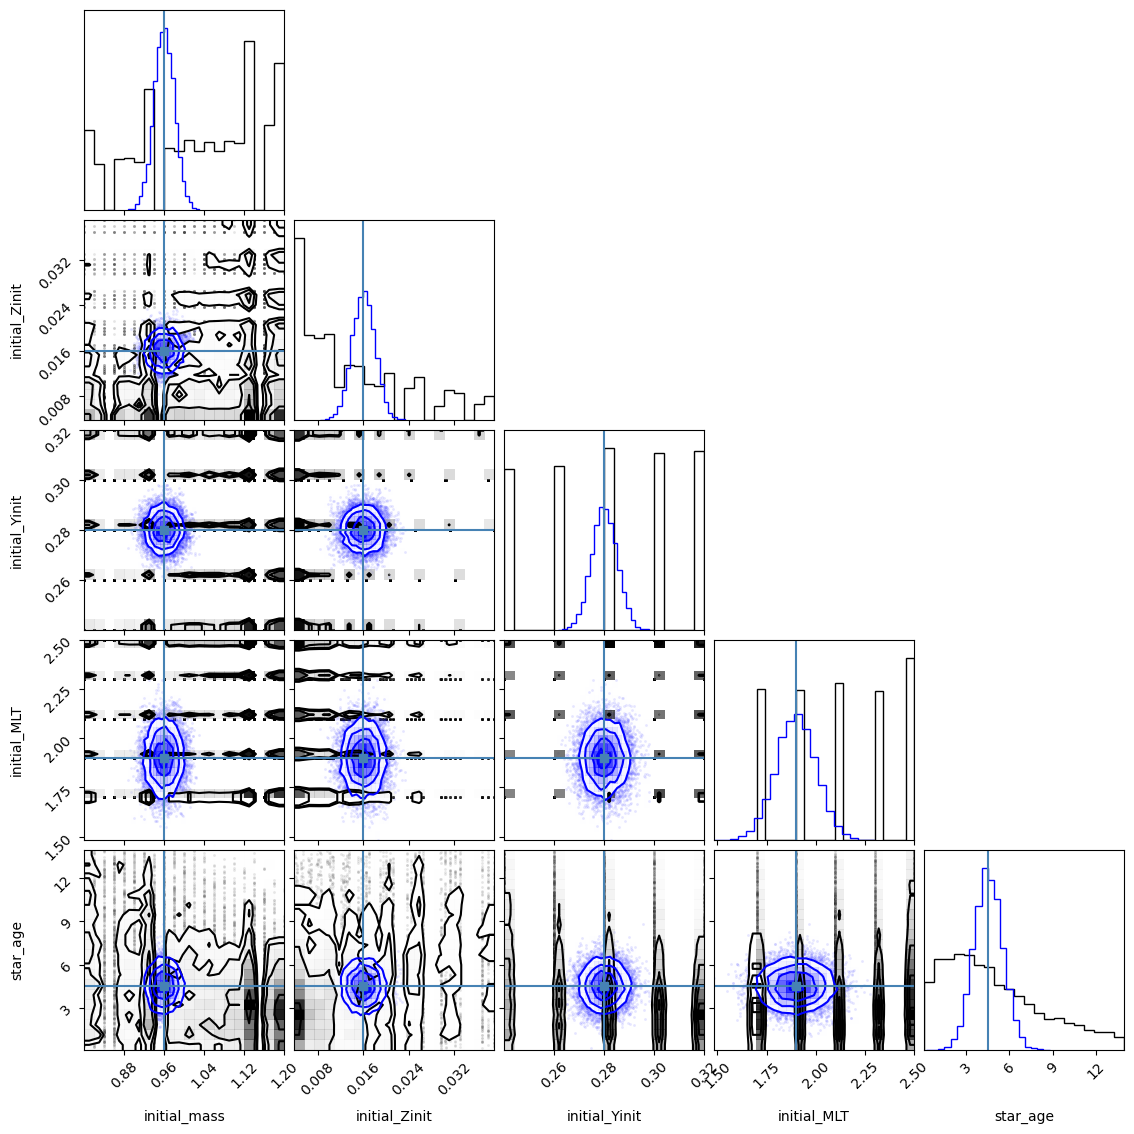

In [6]:
"""
Define priors
"""

def uniform_prior(model_inps, header, scale):
    return scipy.stats.uniform(loc=(1-scale)*model_inps[header], scale=(1+scale)*model_inps[header]-(1-scale)*model_inps[header])

def normal_prior(model_inps, header, scale):
    return scipy.stats.norm(loc=model_inps[header], scale=scale)

mass_prior = normal_prior(model_inps, "initial_mass", 0.02)

Zinit_prior = normal_prior(model_inps, "initial_Zinit", 0.002)

Yinit_prior = normal_prior(model_inps, "initial_Yinit", 0.005)

MLT_prior = normal_prior(model_inps, "initial_MLT", 0.1)

age_prior = normal_prior(model_inps, "star_age", 1)

priors = [mass_prior,Zinit_prior, Yinit_prior, MLT_prior, age_prior]

figure = corner.corner(df[inputs].sample(n=10000));

prior_samples = np.array([mass_prior.rvs(size=10000),Zinit_prior.rvs(size=10000), Yinit_prior.rvs(size=10000), MLT_prior.rvs(size=10000), age_prior.rvs(size=10000)]).T
corner.corner(prior_samples, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='blue', fig=figure);

In [7]:
pitchfork = emulator("nu6-40")

2024-03-21 14:46:38.777832: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 17982 MB memory:  -> device: 0, name: NVIDIA RTX A4500, pci bus id: 0000:41:00.0, compute capability: 8.6
2024-03-21 14:46:38.778475: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 18447 MB memory:  -> device: 1, name: NVIDIA RTX A4500, pci bus id: 0000:61:00.0, compute capability: 8.6


initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]


In [8]:
"""
Define observed quantities and uncertainties
"""
obs = model_outs.values
unc = [.5, 1, 0.005] + [1 for _ in range(5,40)]

In [8]:
tf.test.gpu_device_name()

2024-03-21 14:46:47.312922: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /device:GPU:0 with 17982 MB memory:  -> device: 0, name: NVIDIA RTX A4500, pci bus id: 0000:41:00.0, compute capability: 8.6
2024-03-21 14:46:47.313142: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /device:GPU:1 with 18447 MB memory:  -> device: 1, name: NVIDIA RTX A4500, pci bus id: 0000:61:00.0, compute capability: 8.6


'/device:GPU:0'

In [15]:
%%timeit
pitchfork.predict(model_inps)

35.9 ms ± 530 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
%%timeit
pitchfork.predict(model_inps)

32.2 ms ± 505 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


2024-03-21 13:23:31.896453: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-21 13:23:31.954417: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
iter: 1249 | +100 | bound: 61 | nc: 1 | ncall: 26174 | eff(%):  5.174 | loglstar:   -inf < -29.710 <    inf | logz: -39.872 +/-  0.300 | dlogz:  0.001 >  0.109                                       

CPU times: user 18min 4s, sys: 3min 40s, total: 21min 44s
Wall time: 15min 58s


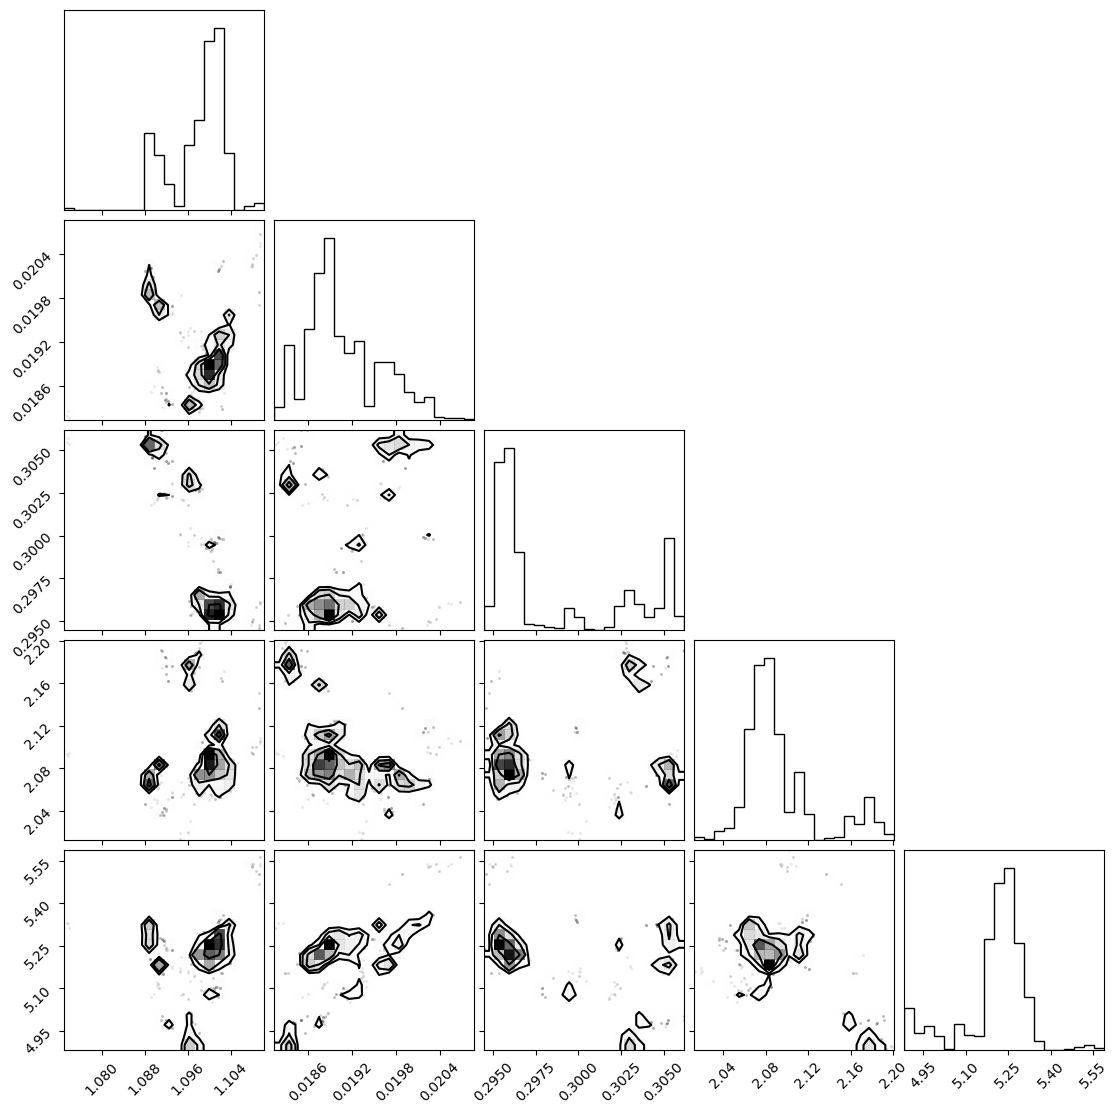

In [8]:
%%time
sampler = ns(priors=priors, observed_vals=obs, observed_unc=unc, pitchfork=pitchfork)
posterior = sampler()

corner.corner(posterior);

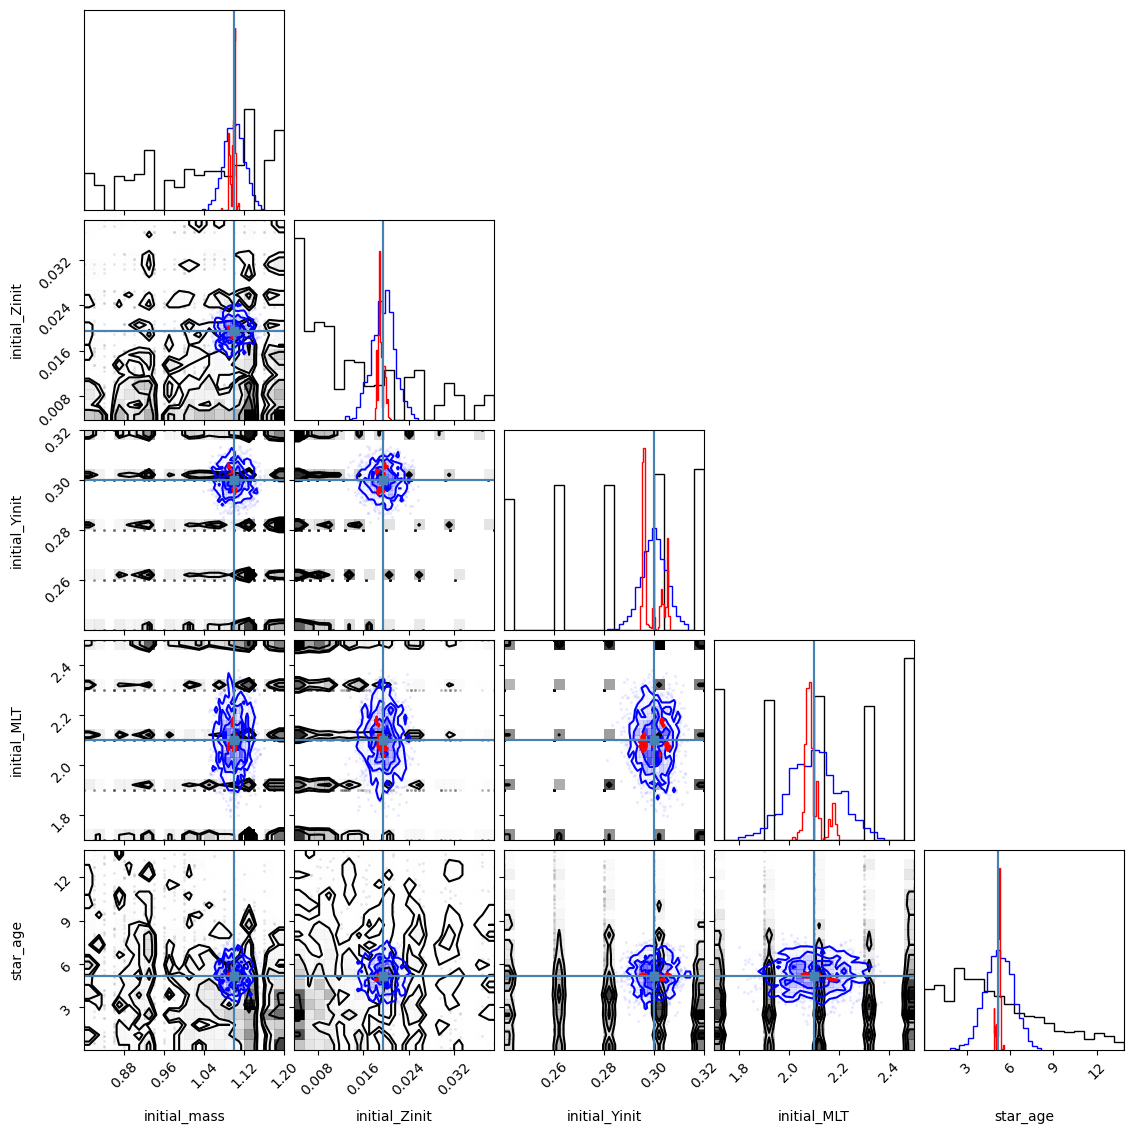

In [9]:
figure = corner.corner(df[inputs].sample(n=posterior.shape[0]));

prior_samples = np.array([mass_prior.rvs(size=posterior.shape[0]),Zinit_prior.rvs(size=posterior.shape[0]), Yinit_prior.rvs(size=posterior.shape[0]), MLT_prior.rvs(size=posterior.shape[0]), age_prior.rvs(size=posterior.shape[0])]).T
corner.corner(prior_samples, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='blue', fig=figure);
corner.corner(posterior, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red', fig=figure);

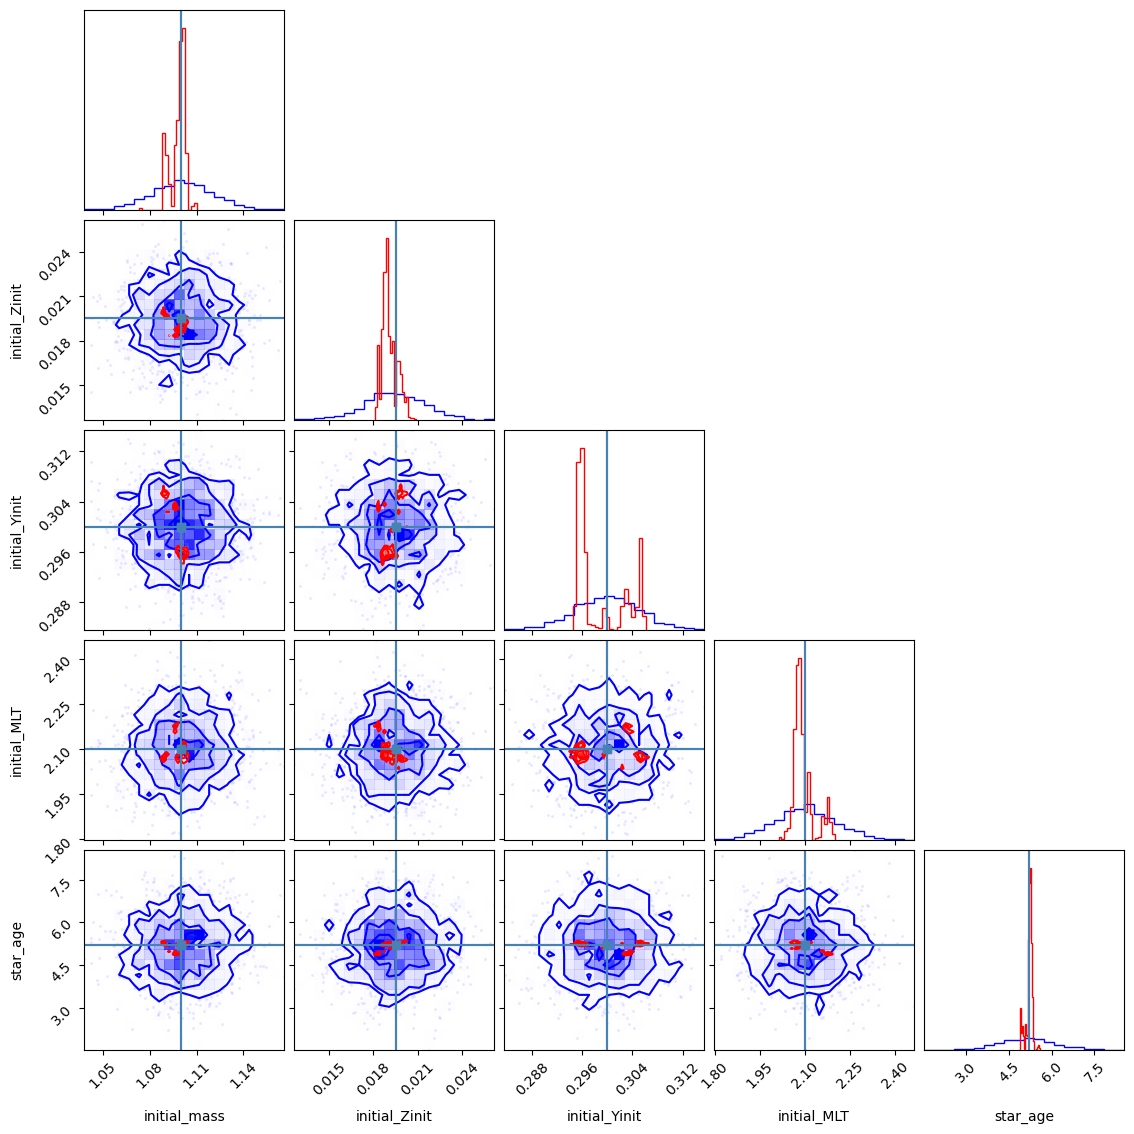

In [12]:
prior_samples = np.array([mass_prior.rvs(size=posterior.shape[0]),Zinit_prior.rvs(size=posterior.shape[0]), Yinit_prior.rvs(size=posterior.shape[0]), MLT_prior.rvs(size=posterior.shape[0]), age_prior.rvs(size=posterior.shape[0])]).T
figure = corner.corner(prior_samples, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='blue',hist_kwargs={'density':True});
corner.corner(posterior, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red', fig=figure,hist_kwargs={'density':True});

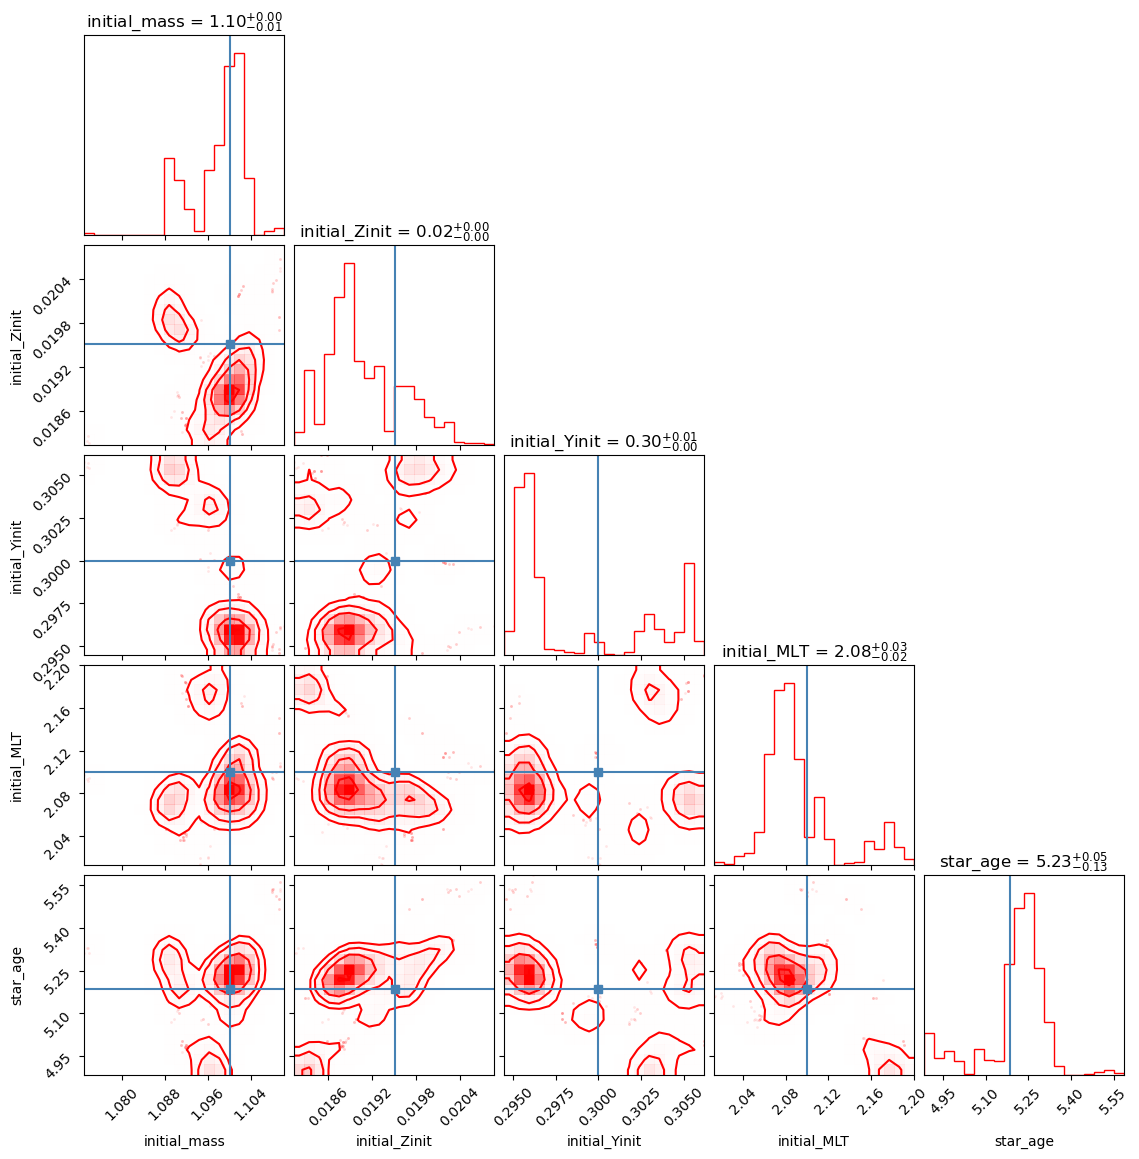

In [11]:
corner.corner(posterior, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red',show_titles=True, smooth=True);